> ### EEE4423: Deep Learning Lab

# Final Project: Long-tail Visual Recognition for Image Classification

<h4><div style="text-align: right"> Due date: June 24, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs and submit via e-mail by 2 PM in the form of [ID_Name_project.ipynb]. </div></h4>

여기서는 두가지 방법을 사용할 것이다.

1) model을 head에 해당하는 곳과 tail에 해당하는 곳 두군대 모두 구한다.

2) LWS 기법을 각각 사용해서 정확도를 높인다.

In [12]:
import os
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from misc.project.utils import resnet18, IMBALANCECIFAR10, IMBALANCECIFAR100, compute_accuracy
from torch.nn.parameter import Parameter

import warnings
warnings.filterwarnings("ignore", category=UserWarning) ## 경고 무시

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [13]:
print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

DATASET = 'CIFAR10' #['CIFAR10', 'CIFAR100']
IMB_TYPE = 'exp' #['exp', 'step'] # 질문
IMB_FACTOR = 0.1 #[0.1, 0.01]
SAVE_DIR = 'logs/final/CIFAR10/exp-0.1' 

LR = 0.1
BATCH_SIZE = 128 
MOMENTUM = 0.9
WEIGHT_DECAY = 2e-4
EPOCHS = 100

STEP 6: INSTANTIATE OPTIMIZER CLASS


In [14]:
os.makedirs(osp.join(SAVE_DIR), exist_ok=True)

In [15]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if DATASET == 'CIFAR10':
    train_dataset_0 = IMBALANCECIFAR10(root='../dataset/project', imb_type=IMB_TYPE, imb_factor=IMB_FACTOR, train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='../dataset/project', train=False, download=True, transform=transform_test)
elif DATASET == 'CIFAR100':
    train_dataset_0 = IMBALANCECIFAR100(root='../dataset/project', imb_type=IMB_TYPE, imb_factor=IMB_FACTOR, train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR100(root='../dataset/project', train=False, download=True, transform=transform_test)

cls_num_list = train_dataset_0.get_cls_num_list() # 각 class에 몇개가 들어있는지 나타냄 
print('cls num list:')
print(cls_num_list)
num_classes = len(cls_num_list)
print(num_classes)

STEP 1: LOADING DATASET
Files already downloaded and verified
Files already downloaded and verified
cls num list:
[5000, 3871, 2997, 2320, 1796, 1391, 1077, 834, 645, 500]
10


In [16]:
list_val = []
for i in cls_num_list :
    if i < 10 :
        k = 1
        list_val.append(k)
    elif i >= 10 :
        k = int(i*0.1)
        list_val.append(k)
print(list_val)
list_v_t = []
for i in range(num_classes) :
    list_v_t.append(cls_num_list[i] - list_val[i])
print(list_v_t)

[500, 387, 299, 232, 179, 139, 107, 83, 64, 50]
[4500, 3484, 2698, 2088, 1617, 1252, 970, 751, 581, 450]


In [17]:
from torch.utils.data import Dataset, DataLoader, random_split
torch.manual_seed(torch.initial_seed())
generator = torch.Generator()
generator.manual_seed(0)
dataset_size = len(train_dataset_0)
validation_size = int(dataset_size * 0.1) if not int(dataset_size * 0.1)==0 else 1 
train_size = dataset_size - validation_size
test_size = 0

train_dataset, validation_dataset, test_dataset_0 = random_split(train_dataset_0, [train_size, validation_size, test_size],generator=generator)

print(len(train_dataset_0))
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset_0))

20431
18388
2043
0


In [18]:
print('STEP 2: MAKING DATASET ITERABLE')
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False,
    num_workers=4, )

STEP 2: MAKING DATASET ITERABLE


In [19]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.backbone = resnet18()
        self.classifier = nn.Linear(512, num_classes)
        self.scales = Parameter(torch.ones(num_classes))
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(batch_size, -1)
        pred = self.classifier(x)
        # LWS 구현
        pred *= self.scales
#         print(pred.size()) # torch.Size([128, 10])
        return pred

STEP 3: CREATE MODEL CLASS (VGG16)


In [20]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head = model_head.cuda()
model_tail = model_tail.cuda()

print('STEP 5: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()
optimizer_head = torch.optim.SGD(model_head.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer_tail = torch.optim.SGD(model_tail.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler_head = torch.optim.lr_scheduler.StepLR(optimizer_head, step_size=150, gamma=0.1)
scheduler_tail = torch.optim.lr_scheduler.StepLR(optimizer_tail, step_size=150, gamma=0.1)

STEP 4: INSTANTIATE MODEL CLASS
STEP 5: INSTANTIATE LOSS CLASS


In [21]:
torch.cuda.empty_cache()

In [25]:
print('STEP 7: TRAIN THE MODEL')
cri=num_classes//2-1
max_norm = 5

for epoch in range(EPOCHS):
    loss_history = []
    # train
    model_head.train()
    model_tail.train()
    for batch_index, data in enumerate(train_loader):
        image, target = data
        image, target = image.cuda(), target.cuda()
        
        image_tail = image[target>cri]
        target_tail = target[target>cri]
        image_head = image[target<=cri]
        target_head = target[target<=cri]
            
        pred_head = model_head(image_head)
        loss_head = criterion(pred_head, target_head)
        optimizer_head.zero_grad()
        loss_head.backward()
        optimizer_head.step()
        
        if target_tail.size()[0] == 1 :
            image_tail=torch.cat([image_tail, image_tail])
            target_tail = torch.cat([target_tail, target_tail])
            
        if target_tail.size()[0] == 0 :
            loss = loss_head
#             print('ok')
        else :
            pred_tail = model_tail(image_tail)
            loss_tail = criterion(pred_tail, target_tail)
            optimizer_tail.zero_grad()
            optimizer_tail.zero_grad()
            loss_tail.backward()
            torch.nn.utils.clip_grad_norm_(model_tail.parameters(), max_norm)
            optimizer_tail.step()     
            loss = loss_head+loss_tail

        loss_history.append(loss.item())
        
    # eval
    topk_acc, head_acc_ok, tail_acc = compute_accuracy(val_loader, model_head)
    topk_acc, head_acc, tail_acc_ok = compute_accuracy(val_loader, model_tail)
    
    topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
    tail_acc = tail_acc_ok[0]
    head_acc = head_acc_ok[0]
    
    loss_mean = np.mean(loss_history)
    scheduler_head.step()
    scheduler_tail.step()

    print('Epoch: [{:03d}] \t Loss {:.4f} \t Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(epoch+1, loss_mean, topk_acc, head_acc, tail_acc))

STEP 7: TRAIN THE MODEL
Epoch: [001] 	 Loss 8.4077 	 Acc 9.22 	 AccHead 11.30 	 AccTail 7.14
Epoch: [002] 	 Loss 6.9037 	 Acc 13.93 	 AccHead 16.39 	 AccTail 11.47
Epoch: [003] 	 Loss 6.6006 	 Acc 13.81 	 AccHead 16.79 	 AccTail 10.82
Epoch: [004] 	 Loss 6.3439 	 Acc 18.07 	 AccHead 23.14 	 AccTail 12.99
Epoch: [005] 	 Loss 6.1162 	 Acc 21.33 	 AccHead 24.48 	 AccTail 18.18
Epoch: [006] 	 Loss 5.9234 	 Acc 20.84 	 AccHead 27.83 	 AccTail 13.85
Epoch: [007] 	 Loss 5.7197 	 Acc 21.45 	 AccHead 27.09 	 AccTail 15.80
Epoch: [008] 	 Loss 5.5644 	 Acc 24.35 	 AccHead 30.30 	 AccTail 18.40
Epoch: [009] 	 Loss 5.3618 	 Acc 25.02 	 AccHead 30.57 	 AccTail 19.48
Epoch: [010] 	 Loss 5.1676 	 Acc 27.57 	 AccHead 31.77 	 AccTail 23.38
Epoch: [011] 	 Loss 5.0363 	 Acc 27.87 	 AccHead 35.18 	 AccTail 20.56
Epoch: [012] 	 Loss 4.9065 	 Acc 28.90 	 AccHead 34.65 	 AccTail 23.16
Epoch: [013] 	 Loss 4.7776 	 Acc 30.89 	 AccHead 38.19 	 AccTail 23.59
Epoch: [014] 	 Loss 4.6570 	 Acc 32.63 	 AccHead 39.93 

Epoch: [117] 	 Loss 1.2859 	 Acc 42.05 	 AccHead 47.96 	 AccTail 36.15
Epoch: [118] 	 Loss 1.2392 	 Acc 41.88 	 AccHead 47.83 	 AccTail 35.93
Epoch: [119] 	 Loss 1.2544 	 Acc 40.03 	 AccHead 45.22 	 AccTail 34.85
Epoch: [120] 	 Loss 1.2328 	 Acc 42.40 	 AccHead 46.49 	 AccTail 38.31
Epoch: [121] 	 Loss 1.2029 	 Acc 41.00 	 AccHead 46.29 	 AccTail 35.71
Epoch: [122] 	 Loss 1.1700 	 Acc 42.28 	 AccHead 47.76 	 AccTail 36.80
Epoch: [123] 	 Loss 1.2473 	 Acc 41.08 	 AccHead 46.02 	 AccTail 36.15
Epoch: [124] 	 Loss 1.1719 	 Acc 41.09 	 AccHead 45.82 	 AccTail 36.36
Epoch: [125] 	 Loss 1.1697 	 Acc 41.48 	 AccHead 47.89 	 AccTail 35.06
Epoch: [126] 	 Loss 1.2424 	 Acc 43.72 	 AccHead 46.96 	 AccTail 40.48
Epoch: [127] 	 Loss 1.2323 	 Acc 40.88 	 AccHead 43.88 	 AccTail 37.88
Epoch: [128] 	 Loss 1.1975 	 Acc 41.86 	 AccHead 46.49 	 AccTail 37.23
Epoch: [129] 	 Loss 1.1933 	 Acc 41.36 	 AccHead 48.09 	 AccTail 34.63
Epoch: [130] 	 Loss 1.1803 	 Acc 41.29 	 AccHead 46.22 	 AccTail 36.36
Epoch:

In [26]:
torch.save({
    'model_head': model_head.state_dict(),
    'optimizer_head': optimizer_head.state_dict(),
    'model_tail': model_tail.state_dict(),
    'optimizer_tail': optimizer_tail.state_dict(),
    'epoch': epoch},
    osp.join(SAVE_DIR, 'ep{:03d}.pth'.format(epoch+1))
)

In [12]:
SAVE_DIR = 'logs/final/CIFAR10/exp-0.1' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 82.06 	 AccHead 83.66 	 AccTail 80.46


In [13]:
SAVE_DIR = 'logs/final/CIFAR10/exp-0.01' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 61.10 	 AccHead 75.32 	 AccTail 46.88


In [14]:
SAVE_DIR = 'logs/final/CIFAR10/step-0.1' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 79.66 	 AccHead 84.58 	 AccTail 74.74


In [15]:
SAVE_DIR = 'logs/final/CIFAR10/step-0.01' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 50.53 	 AccHead 86.80 	 AccTail 14.26


In [27]:
SAVE_DIR = 'logs/final/CIFAR100/exp-0.1' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 41.39 	 AccHead 47.48 	 AccTail 35.30


In [28]:
SAVE_DIR = 'logs/final/CIFAR100/exp-0.01' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 28.07 	 AccHead 40.16 	 AccTail 15.98


In [29]:
SAVE_DIR = 'logs/final/CIFAR100/step-0.1' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 39.09 	 AccHead 54.28 	 AccTail 23.90


In [30]:
SAVE_DIR = 'logs/final/CIFAR100/step-0.01' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep100.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 27.62 	 AccHead 54.10 	 AccTail 1.14


이건 CIFAR100에서 경향성을 알기 위해 epoch200까지 돌린 결과이다. 

In [31]:
SAVE_DIR = 'logs/final/CIFAR100/exp-0.1' 
model_head = ResNet18(num_classes)
model_tail = ResNet18(num_classes)
model_head.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep200.pth')
)['model_head'])
model_tail.load_state_dict(torch.load(
    osp.join(SAVE_DIR, 'ep200.pth')
)['model_tail'])
model_head = model_head.cuda()
model_tail = model_tail.cuda()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

Acc 48.56 	 AccHead 54.34 	 AccTail 42.78


실행 시간을 위한 코드

In [22]:
print('STEP 7: TRAIN THE MODEL')
cri=num_classes//2-1
max_norm = 5

import time 

train_start_time = time.time()

for epoch in range(EPOCHS):
    loss_history = []
    # train
    model_head.train()
    model_tail.train()
    for batch_index, data in enumerate(train_loader):
        image, target = data
        image, target = image.cuda(), target.cuda()
        
        image_tail = image[target>cri]
        target_tail = target[target>cri]
        image_head = image[target<=cri]
        target_head = target[target<=cri]
            
        pred_head = model_head(image_head)
        loss_head = criterion(pred_head, target_head)
        optimizer_head.zero_grad()
        loss_head.backward()
        optimizer_head.step()
        
        if target_tail.size()[0] == 1 :
            image_tail=torch.cat([image_tail, image_tail])
            target_tail = torch.cat([target_tail, target_tail])
            
        if target_tail.size()[0] == 0 :
            loss = loss_head
#             print('ok')
        else :
            pred_tail = model_tail(image_tail)
            loss_tail = criterion(pred_tail, target_tail)
            optimizer_tail.zero_grad()
            optimizer_tail.zero_grad()
            loss_tail.backward()
            torch.nn.utils.clip_grad_norm_(model_tail.parameters(), max_norm)
            optimizer_tail.step()     
            loss = loss_head+loss_tail

        loss_history.append(loss.item())
        
    # eval
    topk_acc, head_acc_ok, tail_acc = compute_accuracy(val_loader, model_head)
    topk_acc, head_acc, tail_acc_ok = compute_accuracy(val_loader, model_tail)
    
    topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
    tail_acc = tail_acc_ok[0]
    head_acc = head_acc_ok[0]
    
    loss_mean = np.mean(loss_history)
    scheduler_head.step()
    scheduler_tail.step()

    print('Epoch: [{:03d}] \t Loss {:.4f} \t Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(epoch+1, loss_mean, topk_acc, head_acc, tail_acc))

train_end_time = time.time()

print(train_end_time-train_start_time)

STEP 7: TRAIN THE MODEL
Epoch: [001] 	 Loss 4.1206 	 Acc 33.18 	 AccHead 38.05 	 AccTail 28.30
Epoch: [002] 	 Loss 2.7381 	 Acc 48.15 	 AccHead 52.44 	 AccTail 43.87
Epoch: [003] 	 Loss 2.4852 	 Acc 52.66 	 AccHead 57.44 	 AccTail 47.88
Epoch: [004] 	 Loss 2.2800 	 Acc 54.37 	 AccHead 58.74 	 AccTail 50.00
Epoch: [005] 	 Loss 2.1457 	 Acc 60.75 	 AccHead 63.00 	 AccTail 58.49
Epoch: [006] 	 Loss 1.9617 	 Acc 62.36 	 AccHead 62.45 	 AccTail 62.26
Epoch: [007] 	 Loss 1.9203 	 Acc 59.98 	 AccHead 59.11 	 AccTail 60.85
Epoch: [008] 	 Loss 1.7997 	 Acc 59.59 	 AccHead 65.16 	 AccTail 54.01
Epoch: [009] 	 Loss 1.7629 	 Acc 68.16 	 AccHead 70.29 	 AccTail 66.04
Epoch: [010] 	 Loss 1.6852 	 Acc 70.46 	 AccHead 71.59 	 AccTail 69.34
Epoch: [011] 	 Loss 1.6154 	 Acc 71.19 	 AccHead 70.91 	 AccTail 71.46
Epoch: [012] 	 Loss 1.5355 	 Acc 70.19 	 AccHead 73.63 	 AccTail 66.75
Epoch: [013] 	 Loss 1.5088 	 Acc 70.86 	 AccHead 74.74 	 AccTail 66.98
Epoch: [014] 	 Loss 1.4578 	 Acc 72.87 	 AccHead 73.5

In [23]:
train_start_time = time.time()

topk_acc, head_acc_ok, tail_acc = compute_accuracy(test_loader, model_head)
topk_acc, head_acc, tail_acc_ok = compute_accuracy(test_loader, model_tail)
topk_acc = (head_acc_ok[0]+ tail_acc_ok[0])/2
tail_acc = tail_acc_ok[0]
head_acc = head_acc_ok[0]
print('Acc {:.2f} \t AccHead {:.2f} \t AccTail {:.2f}'.format(topk_acc, head_acc, tail_acc))

train_end_time = time.time()

print(train_end_time-train_start_time)

Acc 81.12 	 AccHead 80.38 	 AccTail 81.86
10.042887687683105


여기서는 결과를 살펴볼 것이다. 

In [75]:
import matplotlib.pyplot as plt
example = next(iter(test_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3)


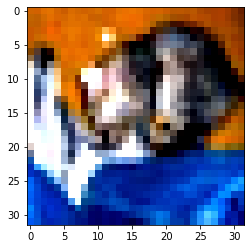

In [58]:
example_image = example[0][0]
example_label = example[1][0]
example_image = (example_image+1)/2
example_image = example_image.cpu().data.numpy()
example_image = np.transpose(example_image, [1,2,0])
plt.imshow(example_image)
print(example_label)

In [71]:
example_image = example[0][0]
data_test=example_image.unsqueeze(0)
data_test = data_test.cuda()

In [72]:
pred_head = model_head(data_test)
pred_tail = model_tail(data_test)
print(pred_head)
print(pred_tail)

tensor([[ -3.3564,  -2.9364,  -4.9331,   3.3350,  -2.6883, -10.8467, -10.8931,
         -10.8949, -10.8388, -10.8795]], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([[-10.9268, -10.9313, -10.9291, -10.9262, -10.9306,   0.8470,  -2.0368,
          -2.9228,  -7.0908,  -6.8276]], device='cuda:0',
       grad_fn=<MulBackward0>)


In [73]:
pred = torch.cat([pred_head[0][:5],pred_tail[0][5:]])
print(pred)

tensor([-3.3564, -2.9364, -4.9331,  3.3350, -2.6883,  0.8470, -2.0368, -2.9228,
        -7.0908, -6.8276], device='cuda:0', grad_fn=<CatBackward0>)


In [74]:
torch.argmax(pred)

tensor(3, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


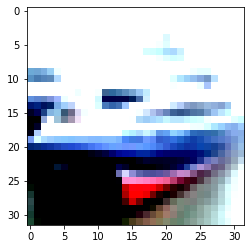

In [76]:
example_image = example[0][1]
example_label = example[1][1]
example_image = (example_image+1)/2
example_image = example_image.cpu().data.numpy()
example_image = np.transpose(example_image, [1,2,0])
plt.imshow(example_image)
print(example_label)

In [77]:
example_image = example[0][1]
data_test=example_image.unsqueeze(0)
data_test = data_test.cuda()
pred_head = model_head(data_test)
pred_tail = model_tail(data_test)
print(pred_head)
print(pred_tail)
pred = torch.cat([pred_head[0][:5],pred_tail[0][5:]])
print(pred)
torch.argmax(pred)

tensor([[ 1.8470,  0.3829, -3.0873, -3.9216, -4.5899, -6.9575, -6.9526, -6.9562,
         -6.9638, -6.9557]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-10.7455, -10.7424, -10.7524, -10.7529, -10.7584,  -2.7019,  -4.3051,
          -2.4733,   4.3881,  -1.0011]], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([ 1.8470,  0.3829, -3.0873, -3.9216, -4.5899, -2.7019, -4.3051, -2.4733,
         4.3881, -1.0011], device='cuda:0', grad_fn=<CatBackward0>)


tensor(8, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7)


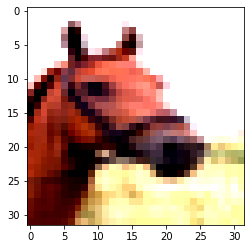

In [78]:
example_image = example[0][99]
example_label = example[1][99]
example_image = (example_image+1)/2
example_image = example_image.cpu().data.numpy()
example_image = np.transpose(example_image, [1,2,0])
plt.imshow(example_image)
print(example_label)

In [79]:
example_image = example[0][99]
data_test=example_image.unsqueeze(0)
data_test = data_test.cuda()
pred_head = model_head(data_test)
pred_tail = model_tail(data_test)
print(pred_head)
print(pred_tail)
pred = torch.cat([pred_head[0][:5],pred_tail[0][5:]])
print(pred)
torch.argmax(pred)

tensor([[-4.0348, -4.8249, -3.2829,  2.5847, -1.0996, -9.5114, -9.5376, -9.5386,
         -9.5094, -9.5313]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-6.3900, -6.3927, -6.3896, -6.3891, -6.3916, -0.1007, -1.4665,  0.5020,
         -4.7876, -2.5988]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([-4.0348, -4.8249, -3.2829,  2.5847, -1.0996, -0.1007, -1.4665,  0.5020,
        -4.7876, -2.5988], device='cuda:0', grad_fn=<CatBackward0>)


tensor(3, device='cuda:0')

In [80]:
example_image = example[0][99]
data_test=example_image.unsqueeze(0)
data_test = data_test.cuda()
pred_head = model_head(data_test)
pred_head_abs = torch.abs(pred_head)
pred_head_sum = torch.sum(pred_head_abs)
pred_head /= pred_head_sum
pred_tail = model_tail(data_test)
pred_tail_abs = torch.abs(pred_tail)
pred_tail_sum = torch.sum(pred_tail_abs)
pred_tail /= pred_tail_sum
print(pred_head)
print(pred_tail)
pred = torch.cat([pred_head[0][:5],pred_tail[0][5:]])
print(pred)
torch.argmax(pred)

tensor([[-0.0636, -0.0760, -0.0517,  0.0407, -0.0173, -0.1499, -0.1503, -0.1503,
         -0.1499, -0.1502]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[-0.1543, -0.1544, -0.1543, -0.1543, -0.1544, -0.0024, -0.0354,  0.0121,
         -0.1156, -0.0628]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([-0.0636, -0.0760, -0.0517,  0.0407, -0.0173, -0.0024, -0.0354,  0.0121,
        -0.1156, -0.0628], device='cuda:0', grad_fn=<CatBackward0>)


tensor(3, device='cuda:0')